In [ ]:
!pip install sqlalchemy ipython-sql seaborn scikit-learn
%load_ext sql
%sql sqlite://


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd

df = pd.read_csv('/content/player_data_january_400_with_errors.csv')
df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   player_id              400 non-null    object 
 1   session_date           400 non-null    object 
 2   play_time_mins         388 non-null    float64
 3   game_genre             380 non-null    object 
 4   achievements_unlocked  392 non-null    float64
 5   in_game_purchases      400 non-null    int64  
 6   region                 380 non-null    object 
 7   churned                400 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 25.1+ KB


,play_time_mins,achievements_unlocked,in_game_purchases,churned
count,388.000000,392.000000,400.000000,400.000000
mean,120.103093,14.783163,1.965000,0.362500
std,48.005703,8.665505,1.394143,0.481324
min,-42.000000,0.000000,0.000000,0.000000
25%,86.000000,7.000000,1.000000,0.000000
50%,121.500000,16.000000,2.000000,0.000000
75%,151.250000,22.000000,3.000000,1.000000
max,312.000000,29.000000,8.000000,1.000000


In [ ]:
%sql DROP TABLE IF EXISTS player_sessions;
%sql CREATE TABLE player_sessions AS SELECT * FROM df;


 * sqlite://
Done.
 * sqlite://
(sqlite3.OperationalError) no such table: df
[SQL: CREATE TABLE player_sessions AS SELECT * FROM df;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [ ]:
%%sql
SELECT region, COUNT(*) AS players, AVG(play_time_mins) AS avg_playtime
FROM player_sessions
GROUP BY region
ORDER BY avg_playtime DESC;


 * sqlite://
(sqlite3.OperationalError) no such table: player_sessions
[SQL: SELECT region, COUNT(*) AS players, AVG(play_time_mins) AS avg_playtime
FROM player_sessions
GROUP BY region
ORDER BY avg_playtime DESC;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [ ]:
%%sql
SELECT game_genre, COUNT(*) AS total_players
FROM player_sessions
GROUP BY game_genre
ORDER BY total_players DESC;


 * sqlite://
(sqlite3.OperationalError) no such table: player_sessions
[SQL: SELECT game_genre, COUNT(*) AS total_players
FROM player_sessions
GROUP BY game_genre
ORDER BY total_players DESC;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [ ]:
import numpy as np

# Fix date formats
df['session_date'] = pd.to_datetime(df['session_date'], errors='coerce')

# Convert and clean numeric columns
for col in ['play_time_mins', 'achievements_unlocked', 'in_game_purchases']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df.loc[df[col] < 0, col] = np.nan

# Clean text columns
df['game_genre'] = df['game_genre'].str.lower().str.strip()
df['region'] = df['region'].str.lower().str.strip().str.replace('_',' ')

# Handle missing values
df.drop_duplicates(inplace=True)
df.dropna(subset=['churned'], inplace=True)


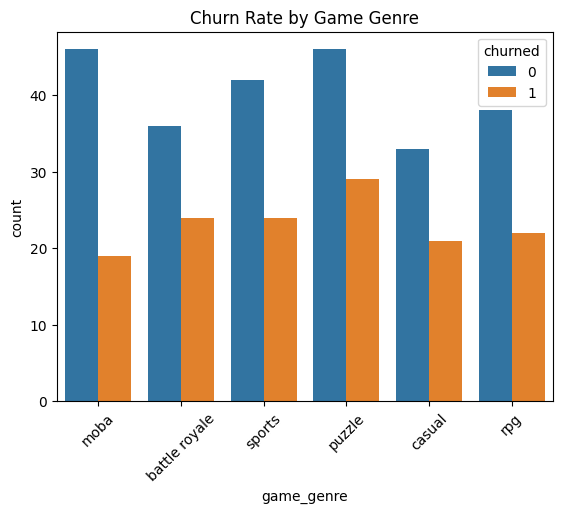

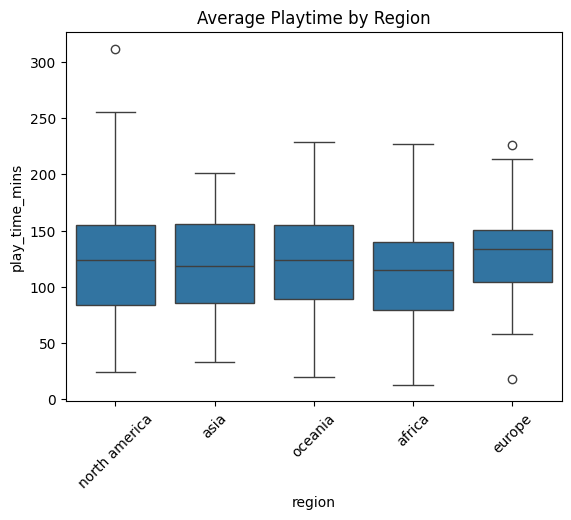

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Churn by Genre
sns.countplot(data=df, x='game_genre', hue='churned')
plt.title("Churn Rate by Game Genre")
plt.xticks(rotation=45)
plt.show()

# Playtime by Region
sns.boxplot(data=df, x='region', y='play_time_mins')
plt.title("Average Playtime by Region")
plt.xticks(rotation=45)
plt.show()


In [ ]:
import pandas as pd

# Grouping by player_id to summarize behavior
player = df.groupby('player_id').agg({
    'play_time_mins': ['sum', 'mean', 'max'],
    'achievements_unlocked': 'sum',
    'in_game_purchases': 'sum',
    # Safe mode() extraction (no error if empty)
    'region': lambda x: x.mode().iloc[0] if not x.mode().empty else 'unknown',
    'game_genre': lambda x: x.mode().iloc[0] if not x.mode().empty else 'unknown',
    # If churned once, mark churned
    'churned': 'max'
})

# Flatten multi-level column names
player.columns = ['_'.join(col).strip() for col in player.columns.values]
player.reset_index(inplace=True)

# View first few rows
player.head()


,player_id,play_time_mins_sum,play_time_mins_mean,play_time_mins_max,achievements_unlocked_sum,in_game_purchases_sum,region_<lambda>,game_genre_<lambda>,churned_max
0,P1000,144.0,144.0,144.0,10.0,8.0,north america,moba,0
1,P1001,113.0,113.0,113.0,11.0,1.0,asia,battle royale,0
2,P1002,152.0,152.0,152.0,25.0,1.0,oceania,sports,0
3,P1003,196.0,196.0,196.0,12.0,4.0,africa,puzzle,1
4,P1004,108.0,108.0,108.0,7.0,0.0,europe,casual,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

X = player[['play_time_mins_sum','achievements_unlocked_sum','in_game_purchases_sum']]
y = player['churned_max']

X_train, X_test, y_train, y_test = train_test_split(X.fillna(0), y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

           0       0.56      1.00      0.72        45
           1       0.00      0.00      0.00        35

    accuracy                           0.56        80
   macro avg       0.28      0.50      0.36        80
weighted avg       0.32      0.56      0.40        80

ROC AUC: 0.41269841269841273


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
df_feb = pd.read_csv('/content/player_data_february_400_with_errors.csv')

# Quick clean
for col in ['play_time_mins', 'achievements_unlocked', 'in_game_purchases']:
    df_feb[col] = pd.to_numeric(df_feb[col], errors='coerce')

# 🧠 Aggregate February data the SAME way as January
df_feb_agg = df_feb.groupby('player_id').agg({
    'play_time_mins': ['sum', 'mean', 'max'],
    'achievements_unlocked': 'sum',
    'in_game_purchases': 'sum',
    'region': lambda x: x.mode().iloc[0] if not x.mode().empty else 'unknown',
    'game_genre': lambda x: x.mode().iloc[0] if not x.mode().empty else 'unknown'
})

# Flatten columns
df_feb_agg.columns = ['_'.join(col).strip() for col in df_feb_agg.columns.values]
df_feb_agg.reset_index(inplace=True)

# 🎯 Predict churn probability using the trained model
X_feb = df_feb_agg[['play_time_mins_sum', 'achievements_unlocked_sum', 'in_game_purchases_sum']].fillna(0)
df_feb_agg['predicted_churn'] = model.predict_proba(X_feb)[:, 1]

# 👀 See first few predictions
df_feb_agg.head()



,player_id,play_time_mins_sum,play_time_mins_mean,play_time_mins_max,achievements_unlocked_sum,in_game_purchases_sum,region_<lambda>,game_genre_<lambda>,predicted_churn
0,P1000,149.0,149.0,149.0,15.0,5,Oceania,Battle Royale,0.297749
1,P1001,0.0,NaN,NaN,0.0,4,Europe,Battle Royale,0.277928
2,P1002,198.0,198.0,198.0,11.0,4,Oceania,MOBA,0.313167
3,P1003,96.0,96.0,96.0,23.0,2,Asia,RPG,0.353699
4,P1004,206.0,206.0,206.0,33.0,2,Africa,RPG,0.381622


In [ ]:
df_feb.to_csv('player_predictions.csv', index=False)
player.to_csv('player_aggregated.csv', index=False)


In [ ]:
from google.colab import files
files.download('player_predictions.csv')
files.download('player_aggregated.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>